# JSON model definition and folder import
Often, it is more convenient to define all (or many) of the model parameters in input files rather than in scripts. To simplify this process, a support function `wawi.io.import_folder` is provided in WAWI.

This imports all files in the specified folder. The file names of the relevant files in the provided path are defined as inputs to the function (default values in parentheses): 

- modal ('modal.json')
- pontoon('pontoon.json')
- pontoon_types ('pontoon_types.json')
- pontoon_stl ('pontoon.stl')
- eldef ('element.json')
- aero_sections ('aero_sections.json')
- orientations ('orientations.json')
- drag_elements ('drag_elements.json')


## Modal definition (modal)
The first file, 'modal.json', defines the dry modes of the structure under consideration. It includes the following fiels

```json
{
  "local": false,
  "phi": {
    "full": [[...]],
    "hydro": [[...]],
    "girder": [[...]],
    "girder_forces": [[...]]
    },

"m": [...],
"omega_n": [...]

```

The `local` parameter defines if the modal transformation matrices (mode shapes) are given in local or global coordinate system. Typically, a global system is more convenient, but both types should work fine in WAWI. The `phi` parameter gives a dictionary defining collections of mode shapes (or modal transformation matrices). The values should be list of lists (inner list is a row) describing the modal transformation matrix of a given key. The matrices have dimensions dofs-by-modes. The keys 'full' and 'hydro' are defaults in WAWI for the full model (used for plotting and convenient for aerodynamic analysis) and pontoon loading, respectively (they can be modified, but sticking with the defaults is a good choice). Furthermore, at least two of the following modal parameters must be given: `m` (modal mass) and `omega_n` (undamped natural frequencies in rad/s) or `m` and `k` (modal stiffness). All of these are 1d lists with length matching the number of columns in all entries in `phi`.

## Pontoon and pontoon types (pontoon, pontoon_types, pontoon_stl)
All pontoon-related definitions are given by the files `pontoon.json`, `pontoon_types.json` and `pontoon.stl`. 

Firstly, `pontoon.json` defines pontoon coordinates, orientations and pontoon type definition, as follows:

```json
{
  "P1": {
    "coordinates": [
      0.0,
      0.0|,
      0.0
    ],
    "pontoon_type": "ptype_1",
    "rotation": 0,
    "node": 1
  },
  "P2": {
    "coordinates": [
      100.0,
      0.0,
      0.0
    ],
    "pontoon_type": "ptype_1",
    "rotation": 12.5,
    "node": 2
  }
}

```

This defines two pontoons (named P1 and P2), places them at coordinates (0,0,0) and (100.0, 0, 0) with orientation (0 deg and 12.5 deg), assigns pontoon type from files "ptype_1.npz". Also, the `node` parameter connects the pontoons to nodes 1 and 2, which should be present in the node matrix of the full system (see `node_matrix` in `element.json`). When a pontoon is connected to a node, the pontoon is automatically plotted together with the elements when using the plotting methods of the model (both rotation and location of the node is used). Also, the coordinates of the pontoon is overwritten by the coordinates of the node. Only the x and y coordinates of the pontoon matters for the computation, as the resulting wave excitation from irregular wave fields is dependent on the horizontal coordinates. The pontoon type definition is an npz-file containing the following numpy nd arrays:

* Added mass: 'M' (6 x 6 x len(omega))
* Radiation/added damping: 'C' (6 x 6 x len(omega))
* Linear hydrodynamic transfer function matrix: 'Q' (6 x len(theta_Q) x len(omega_Q))
* omega (for mass and damping): 'omega' 
* theta for transfer: 'theta_Q'
* omega for transfer: 'omega_Q'

Second, the file `pontoon_types.json` is usually not needed. It is merely added to enable adding additional properties to the pontoon types, not present in the npz-files. Currently, this is limited to drag coefficients and drag areas for inclusion of linearized drag effects (stochastic linearization). It could look something like this (drag terms ordered as relevant to x, y and z-directions, respectively):

```json
{
    "ptype_1": {
        "Cd": [1.0, 1.0, 2.0],
        "area": [1.0, 2.0, 2.0]
    },

    "ptype_2": {
        "Cd": [0.5, 0.4, 0.8],
        "area": [1.0, 2.0, 2.0]
    }
}

```

If instead a wildcard name is used, these properties are used for all pontoons:

```json
{
    "*": {
        "Cd": [1.0, 1.0, 2.0],
        "area": [1.0, 2.0, 2.0]
    }
}

```

Finally, the `pontoon.stl` file is simply a step file containing the mesh used to visualize pontoons together with the elements in the plotting methods.


## Element definition (eldef)
The file `element.json` defines the elements of the model (for aerodynamic analysis and plotting). It must contain the keys 'element_matrix' and 'node_matrix', and can also contain the fields 'sections' and 'section_assignments'. The two first are list of lists where the innermost lists are rows. These follow the typical convention in input files; rows of the node matrix consist of node label, x-coordinate, y-coordinate and z-coordinate, whereas the rows of the element matrix consist of the element label, label of the first node and label of the second node.

The two latter properties of the files are not used inside WAWI directly (unless using drag elements, see below), but are used for the definition of the elements in the BEEF environmen. It can therefore be useful for if the user for instance wants to calculate the stresses in an element, as all relevant properties are present inside the `eldef` attribute of the `model` object. The `sections` property is assumed self-explanatory from the json example provided. The `section_assignment` property is built up with a list of strings where each entry corresponds to the same-index row of the element matrix.

```json
{
    "element_matrix": [[...]],
    "node_matrix":[[...]],

    "sections": 
    {
        "girder":
            {"E": 210000000000.0, 
            "Iz": 0.09285714285714286, 
            "Iy": 0.09285714285714286, 
            "A": 0.0052928571428571426, 
            "poisson": 0.3, 
            "J": 0.10714285714285714, 
            "m": 45.6272019496974},

        "column":
            {"E": 210000000000.0, 
            "Iz": 0.09285714285714286, 
            "Iy": 0.09285714285714286, 
            "A": 0.0052928571428571426, 
            "poisson": 0.3, 
            "J": 0.10714285714285714, 
            "m": 45.6272019496974}
    },

    "section_assignments": ["girder", "girder", "girder", "column", "column"]
}

```

## Aerodynamic sections (aero_sections, orientations)
Aerodynamic sections relate aerodynamic properties to the elements defined in the section above. Two definitions are required, and are given in the files
`aero_sections.json` and `orientations.json`.

First, the aerodynamic sections are defined in the `aero_sections.json`-file, as follows:

```json
{
    "girder":
        {
            "B":26.8,
            "D":3.715,

            "Cd":0.679,
            "dCd":-1.022,
            "Cl":-0.3896,
            "dCl":4.0116,
            "Cm":-0.0700,
            "dCm":1.0122,

            "elements": [1000, 1001, 1002, 1003, ...]
        },

    "column":
    {
        "B":3,
        "D":3,

        "Cd":0.679,
        "dCd":-1.022,
        "Cl":-0.3896,
        "dCl":4.0116,
        "Cm":-0.0700,
        "dCm":1.0122,

        "elements": [2001, 2002, 2003, 2004, 2005, ...]
    }
}
```

Here, two aerodynamic sections are defined. This includes definitions of width (B), height (D), static wind coefficients (Cd, dCd, Cl, dCl, Cm, and dCm - see `wawi.model.aero.AeroSection` for details on this) and a list of elements to apply the sections to.

For aerodynamic analysis, the orientations of the elements are crucial. These are defined in the second file (`orientations.json`). The following structure is used for this:

```json
{
    "girder": {
        "e3": [0,0,1],
        "elements": [1000, 1001, 1002, 1003, ...]
        
    },
    "column": {
        "e2": [0,1,0],
        "elements": [2001, 2002, 2003, 2004, 2005, ...]
    }
}

    
```

In the above snippet, two definitions of orientations are given. Note that the keys here are not used for anything (and are not related to the `aero_sections.json` keys); they are merely included to make it convenient for the user to maintain a structured model setup. The orientation is given by either `e2` or `e3`, indicating if the y/drag or z/lift of the element is defined. Note also that these definitions are assumed approximate; the procedure inside WAWI consists of taking a cross product between the supplied unit vector and the axial direction of the element, which gives a proper perpendicular vector. The last perpendicular vector is thereafter based on a secondary cross product between the calculated perpendicular unit vector and the longitudinal vector. Finally, a list of elements to assign the orientation to is provided. The resulting orientation is conveniently plotted in the model using `model.plot(tmat_on=['undeformed'], tmat_scaling=100)` (adjust `scaling` to make sense for your problem).

## Drag elements (drag_elements)
To accomodate the possibility for floating bridges to have mooring lines with significant quadratic drag damping, an additional file for defining these properties is supported. Note that this, as for the drag of the pontoons, is only solved in a linearized sense using (approximate) stochastic linearization techniques. The `drag_elements.json` file is defined as follows:

```json
{
    "mooring_wire":
        {   "sections": "MooringWire",
            "zrange": [-1e4, 0.0],
            "rho": 1025.0,
            "Cd": [0.1, 1.2, 1.2],
            "D": 0.146}
}
```

For the drag element group named "mooring_wire" above, all elements present in the elements assigned with the relevant section assignment(s) in `element.json` (either list of several strings or single string defined with property `sections`) and that have a z-coordinate inside the provided `zrange` will be given quadratic drag damping according to the specified density (`rho`), drag coefficients in local x, y and z-direction (`Cd`) and diameter (`D`).

## Example import
The folder ./model/ contains the following files:

![](files.png "Files")

Note that these are named as the default values of all the relevant inputs, so they are therefore not defined below. The following code snippet imports the folder and returns a WAWI `Model`-object.

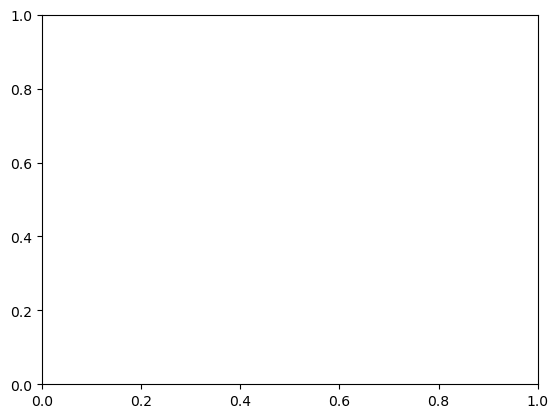

In [4]:
from wawi.io import import_folder
model = import_folder('./model/', sort_nodes_by_x=True)

This model contains a curved floating bridge with columns. No sections in the `element.json` file matches the section definitions in the `drag_elements.json` file, so no drag elements are used (the file is still provided to indicate how it can be defined).

In [6]:
model.plot(tmat_on=['undeformed'])

Widget(value='<iframe src="http://localhost:56089/index.html?ui=P_0x24a1c213140_0&reconnect=auto" class="pyvis…

In [7]:
# Plot dry mode with index 1
model.plot_mode(1, use_dry=True)

Widget(value='<iframe src="http://localhost:56089/index.html?ui=P_0x24a239b0ef0_1&reconnect=auto" class="pyvis…